# Starting with lots of data and a good understanding of that data from *lifespan_of_companies*, we'll make a function to put in an API that will return the probability of a company going out of business in the next 2 years.


## Step 1: get the data ready for analysis

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import elasticsearch
import elasticsearch.helpers
import collections
import re
from pandas.io.json import json_normalize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# Data goes from Elasticsearch into Pandas:
es = elasticsearch.Elasticsearch()

data_to_load = elasticsearch.helpers.scan(
                    es,
                    query={"query": {"match_all": {}}},
                    index="ri_sos",
                    doc_type="corporate_data")

# Initialize a double ended queue
output_all = collections.deque()
# Extend deque with iterator
output_all.extend(data_to_load)
only_data = [item["_source"] for item in output_all]

df = json_normalize(only_data)
print(df.shape)

(43684, 23)


## Add needed variables and, using what we learned in `lifespan_of_companies`, delete bad data
### First our dependent variable: log_time_in_business

In [3]:
# Convert date columns to the date format
df['InactiveDate'] = pd.to_datetime(df['InactiveDate']).dt.date
df['OrganisationDate'] = pd.to_datetime(df['OrganisationDate']).dt.date

# Add the variable 'time_in_business' when we can calculate it:
df.loc[df['InactiveDate'] != np.nan, 'time_in_business'] = (df['InactiveDate'] - df['OrganisationDate']).dt.days

In [4]:
# Find examples where 'time_in_business' is negative (entity disolved before being formed, which is impossible):
weird_rows = df.loc[df.time_in_business < 0]
print(weird_rows.IDNumber)

3011     000000417
29616    000000417
30541    000002273
Name: IDNumber, dtype: object


In [5]:
# If manual inspection shows you should delete them, then delete negatives and 0s:
df.drop(df[df.time_in_business < 1].index, inplace=True)
print("Resulting shape:", df.shape)

Resulting shape: (43677, 24)


In [6]:
df.time_in_business.describe()

count    32455.000000
mean      3515.187829
std       4116.401240
min          1.000000
25%       1030.000000
50%       2120.000000
75%       4303.000000
max      61626.000000
Name: time_in_business, dtype: float64

In [8]:
# This variable is much more appropriate to work with as a log.
# I did a lot of work on the best way to work with this variable in `lifespan_of_companies`, and here's the conclusion:

## TODO: clean this up, do it all on df
first_tib = df[["time_in_business", "IDNumber"]].copy()
first_tib["log_tib"] = np.log(first_tib.time_in_business)
first_tib['masked_tib'] = first_tib['log_tib']
first_tib.loc[first_tib.log_tib < 4, 'masked_tib'] = 4
df["log_time_in_business"] = first_tib['masked_tib']

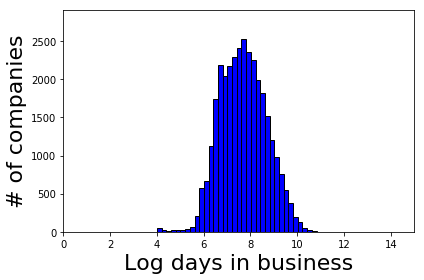

In [11]:
# Graph log_time_in_business:
plt.hist(df.log_time_in_business, bins = 35,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 15])
plt.xlabel('Log days in business', size = 22)
plt.ylabel('# of companies', size= 22)

plt.tight_layout()
plt.show()

### Make variables for the most common and meaningful words in entity's names

In [22]:
# Remove all punctuation from the names of companies
list_of_entity_names = [row[1] for row in df['EntityName'].iteritems()]

list_of_names_w_o_punctuation = []
for name in list_of_entity_names:
    list_of_names_w_o_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
adjusted_words_in_entity_names = []
for words in list_of_names_w_o_punctuation:
    for word in words.split():
        adjusted_words_in_entity_names += [word.lower()]

# Count the occurrence of each word:
name_count = Counter(adjusted_words_in_entity_names)
popular_names = name_count.most_common(300)
print(popular_names[:10])

[('inc', 24190), ('llc', 8618), ('&', 3230), ('corporation', 2117), ('of', 2010), ('the', 1948), ('realty', 1774), ('company', 1739), ('associates', 1604), ('co', 1506)]


In [23]:
# Start by stemming entities names & descriptions. This makes words comparable across conjugations & forms,
# but at a cost of occasionally making the resulting word less intelligible.
stemmer = PorterStemmer()
list_of_stems = [stemmer.stem(word) for word in adjusted_words_in_entity_names]

# Count the occurrence of each word:
stemmed_name_count = Counter(list_of_stems)
stemmed_popular_names = stemmed_name_count.most_common(300)
print(stemmed_popular_names[:10])

[('inc', 24190), ('llc', 8619), ('&', 3230), ('associ', 2492), ('corpor', 2158), ('servic', 2148), ('of', 2010), ('the', 1948), ('realti', 1774), ('compani', 1774)]


In [21]:
# Exclude words either associated with the entity's legal status (we already have a variable for that)
# or that are otherwise meaningless by themselves. 
words_to_exclude = ['inc', 'llc', 'corporation', 'the', 'of', 'company', 'associate', 'co', 'ltd', 'corp', 'and',
                    'enterprise', 'association', 'group', 'associates', 'enterprises', 'incorporated', 'limited',
                    'partnership', 'club', 'in', 'for', 'lp', 'an', 'corpor', 'associ', 'compani', 'incorpor',
                    'busi', 'foundat', 'llp', 'title', 'to', 'as', 'on', 'gl', 'at', 'business', 'operate', 'titl']

worthwhile_entity_words = [item for item in stemmed_popular_names if 
                           item[0] not in words_to_exclude and 
                           len(item[0]) > 1]
print(worthwhile_entity_words[:20])

[('servic', 2148), ('realti', 1774), ('island', 1271), ('rhode', 1106), ('enterpris', 906), ('construct', 896), ('properti', 811), ('manag', 709), ('new', 610), ('develop', 550), ('invest', 535), ('limit', 519), ('system', 487), ('intern', 485), ('center', 483), ('england', 432), ('home', 422), ('auto', 421), ('provid', 410), ('commun', 399)]


### Do a similar process to get the most common and important words in entity's descriptions

In [24]:
# The Comments variable is also called "Purpose" on Rhode Island's website. It's intended to be where companies describe
# what kind of business they intend to do. Most companies give at least a brief answer, but plenty don't.
# My favorite common fake response is "Any Lawful Purpose."

# Remove all punctuation and newline characters
list_of_comments = [row[1] for row in df['Comments'].iteritems()]
list_of_comments_w_o_punctuation = []
for name in list_of_comments:
    name = name.replace('\n', ' ')
    list_of_comments_w_o_punctuation += [re.sub('\,|\.|\!|\;|\:|\?|', '', name)]

# Break each name into a list of words so we can count the occurrence of each word
adjusted_words_in_entity_description = []
for words in list_of_comments_w_o_punctuation:
    for word in words.split():
        adjusted_words_in_entity_description += [word.lower()]

# Just like we did with EntityName, we need to stem the comments:
list_of_stems = [stemmer.stem(word) for word in adjusted_words_in_entity_description]

# Count the occurrence of each word:
comment_count = Counter(list_of_stems)
popular_comments = comment_count.most_common(300)

In [26]:
# Remove words we don't want, including number clusters, which are references to the Rhode Island code, and aren't useful.
def numbers_present(word):
    return any(char.isdigit() for char in word[0])

worthwhile_entity_descriptions = [item for item in popular_comments
                                   if item[0] not in words_to_exclude
                                   and len(item[0]) > 1
                                   and not numbers_present(item)]
print(worthwhile_entity_descriptions[:10])

[('servic', 4385), ('real', 4380), ('estat', 3914), ('sale', 2844), ('oper', 2499), ('manag', 2056), ('provid', 1916), ('sell', 1866), ('develop', 1494), ('engag', 1435)]


### Make variables for whether a company's name or self-description contains the most popular words or not

In [27]:
# These lists are based on the 300 most popular words in names or descriptions (before filtering out words).
# That 300 number is very arbitrary.
all_the_popular_words = [word[0] for word in worthwhile_entity_words]
all_the_popular_words += [word[0] for word in worthwhile_entity_descriptions]
new_variable_list = list(set(all_the_popular_words))
len(new_variable_list)

396

In [41]:
# Add all our new variables to the dataframe
new_keywords = dict.fromkeys(new_variable_list, pd.Series([0] * len(df)))
df = df.assign(**new_keywords)
df.shape

(43677, 421)

In [29]:
# Return a list of all words present in a company's name/description, scrubbed the same way we scrubbed them above
def standardize_names_and_comments(entity_name, self_description):
    combo_phrase = []
    return_phrase = []

    entity_name.replace('\n', ' ')
    self_description.replace('\n', ' ')

    for word in entity_name.split():
        combo_phrase += [word.lower()]
    for word in self_description.split():
        combo_phrase += [word.lower()]

    for word in combo_phrase:
        return_phrase += [re.sub('\,|\.|\!|\;|\:|\?|', '', word)]

    return list(set([stemmer.stem(word) for word in return_phrase if len(word) > 1]))

In [43]:
# Iterate over each row in the df. Figure out which words they share with new_variable_list, and switch that value to 1
for index, row in df.iterrows():
    words_present = standardize_names_and_comments(row['EntityName'], row['Comments'])
    for word in words_present:
        if word in new_variable_list:
            df.at[index, word] = 1

In [44]:
# As long as there are 2 unique values (0 and 1), then we know things worked:
df.real.unique()

array([ 0.,  1., nan])

In [42]:
df.loc[pd.isna(df.real), :]

,Comments,ConsentFlag,EffectiveDate,EntityName,EntityType,IDNumber,InactiveDate,NIACS,OrganisationDate,PrincipleCity,...,usa,societi,promot,lend,develop,trade,not,properti,structur,publish
43677,\r\n\r\nTITLE: 7-16,Y,03-06-2000,"N.A.M. II Investment, LLC",Domestic Limited Liability Company,000111317,2002-10-07,None,2000-03-06,"WARWICK,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43678,"\r\nBAR, RESTAURANT AND LOUNGE\r\nTITLE: 7-16",Y,01-09-1998,"THE SPORTS VIEW BAR, LLC",Domestic Limited Liability Company,000098578,NaT,None,1998-01-09,"WARWICK,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43679,\r\nREAL ESTATE\r\nTITLE: 7-16,Y,11-28-1997,"M & M REALTY ASSOCIATES, LLC",Domestic Limited Liability Company,000097880,NaT,None,1997-11-28,"NEWPORT,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43680,\r\n\r\nTITLE: 7-1.1-51,Y,06-22-1989,GEO REALTY SERVICES. INC,Domestic Profit Corporation,000056382,1993-06-30,None,1989-06-22,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43681,\r\nOWN REAL ESTATE\r\nTITLE: 7-16,Y,02-23-2007,"JENDZA PROPERTIES, LLC",Domestic Limited Liability Company,000162007,2015-11-30,None,2007-02-23,"BARRINGTON,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43682,\r\n\r\nTITLE 7,Y,07-14-1982,Arabian Horse Association of Rhode Island,Domestic Non-Profit Corporation,000026669,NaT,None,1982-07-14,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43683,\r\n\r\nTITLE: 7-16,Y,03-12-2001,"Harold Realty, LLC",Domestic Limited Liability Company,000117272,2003-06-10,None,2001-03-12,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
